# Stock Price Prediction using LSTM
# 
## This notebook demonstrates how to predict stock prices using a Long Short-Term Memory (LSTM) neural network.

## This week's (Week 2) tasks:
### Write a function to load and process a dataset with multiple features with the following requirements:
- a. This function will allow you to specify the start date and the end date for the whole
dataset as inputs.
- b. This function will allow you to deal with the NaN issue in the data.
- c. This function will also allow you to use different methods to split the data into
train/test data; e.g. you can split it according to some specified ratio of train/test and
you can specify to split it by date or randomly.
- d. This function will have the option to allow you to store the downloaded data on your
local machine for future uses and to load the data locally to save time.
- e. This function will also allow you to have an option to scale your feature columns and
store the scalers in a data structure to allow future access to these scalers.

### Create a Virtual Environment using `Conda` (If you have your own `Virutal Environment` your then ignore this !)

In [3]:
# To activate the conda environment, copy the below content to `conda-config.sh` and run the following command in the terminal:
# sh conda-config.sh

'''conda-config.sh

conda create -n cos30019_env_w2_v0.1 python=3.11
conda activate cos30019_env_w2_v0.1
#Check current environment
conda info --envs
#Check current python version
python --version

'''

/ 
CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


# conda environments:
#
base                  *  /Users/cobeo/miniconda3
cos30018-env-w1-p2       /Users/cobeo/miniconda3/envs/cos30018-env-w1-p2
cos30018-env-w1-v0.1     /Users/cobeo/miniconda3/envs/cos30018-env-w1-v0.1
cos30019-env-w1-p1       /Users/cobeo/miniconda3/envs/cos30019-env-w1-p1
fastapi-env              /Users/cobeo/miniconda3/envs/fastapi-env

Python 3.10.6


### Install essential libraries.

In [1]:
!pip install -r requirements.txt
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install tensorflow
# !pip install scikit-learn
# !pip install pandas-datareader
# !pip install yfinance
# !pip install -q talib
# !pip install joblib

### Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import pandas_datareader as pdr
# import datetime as dt
import yfinance as yf
import talib as ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn import metrics

# import tensorflow as tf
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, LSTM, Dropout, InputLayer, Input, Activation
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import plot_model

import pickle
import os
from typing_extensions import Annotated, Doc, TypeVar, Literal, Tuple

### Declare essential variables
- Define the start date, the end date and the ticker (stock) that we wanted to download from `yfinance`.
- Define the split ratio for splitting the train and test data, and the number of days for looking back.
- Define the directory for storing the raw and prepared datasets.
- Define the files that are used for storing essential information, such as raw data imported from yfinance and the processed data.

In [3]:
# Start, end and ticker for the datasets
start="2015-01-01"
end="2023-08-25"
ticker="TSLA"

# Split ratio, 0.8 equals to 80% data for training and 20% for testing
split_ratio = 0.8

# Number of days to look back for the prediction, could be changed to any value
num_look_back_days = 30

# Define entry directory for the raw and prepared datasets
ENTRY_POINT = f"datasets/{ticker}/from_{start}_to_{end}"
RAW_DATA_DIRECTORY = os.path.join(ENTRY_POINT, "data")
PREPARED_DATA_DIRECTORY = os.path.join(ENTRY_POINT, "prepared-data")

# Raw data to be saved as the same for
RAW_CSV_FILE = os.path.join(RAW_DATA_DIRECTORY, f"raw_data_from_{start}_to_{end}_of_{ticker}_stock.csv")

# Prepared data to be saved as the same for
PREPARED_CSV = os.path.join(PREPARED_DATA_DIRECTORY, f"prepared_data_from_{start}_to_{end}_of_{ticker}_stock.csv")
PREPARED_TRAIN_ALL = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_data_{start}-{end}-{ticker}_stock.npz")
PREPARED_TRAIN_DATASET = os.path.join(PREPARED_DATA_DIRECTORY, f"train_dataset_of_{ticker}_from_{start}_to_{end}.csv")
PREPARED_TEST_DATASET = os.path.join(PREPARED_DATA_DIRECTORY, f"test_dataset_of_{ticker}_from_{start}_to_{end}.csv")
PREPARED_SCALER_FEATURE = os.path.join(PREPARED_DATA_DIRECTORY, f"feature_scaler_of_{ticker}_from_{start}_to_{end}.pkl")
PREPARED_SCALER_TARGET = os.path.join(PREPARED_DATA_DIRECTORY, f"targe_scaler_of_{ticker}_from_{start}_to_{end}.pkl")
PREPARED_TRAIN_ARRAY = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_train_array_of_{ticker}_from_{start}_to_{end}.npz")
PREPARED_TEST_ARRAY = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_test_array_of_{ticker}_from_{start}_to_{end}.npz")

### Ensure that directory must exists
- check_directory_exists() & create_directory(): The purpose of these two functions are two check if the given dir_path is exists or not using os.path.isdir(), if not then the check_directory_exists() will return a False and use create_directory() to create a folder based on the given dir_path, otherwise return True. 
- check_file_exists(): This function will check if the file exists using os.path.exists() function, it will return True if exists otherwise return False.

In [4]:
def check_directory_exists(dir_path: Annotated[str, Doc("The path to the directory to be checked")]) -> bool:
    return True if os.path.isdir(dir_path) else False

def create_directory(dir_path: Annotated[str, Doc("The path to the directory to be created")]) -> None:
    os.makedirs(dir_path)

def check_file_exists(file_path: Annotated[str, Doc("The path to the file to be checked")]) -> bool:
    return True if os.path.exists(file_path) else False

### Utility function to load and save data objects
**The load_and_save_object() function does the following procedure:**
- If the mode is set to save, the function will start opening up the file defined in fn parameter. Once the file is successfully opened, it will write all of the given objects defined in obj by using pickle.dump() to ensure that the object will be type-safe when loading the object from the file.
- If the mode is set to load, the function will start reading from the file defined in fn and load the object using pickle.load() function

In [5]:
T = TypeVar("T", bound=Literal["load", "save"])
U = TypeVar("U", any, object)
def save_or_load_object(obj: Annotated[U | None, Doc("The object to be saved or loaded")],
                         fn: Annotated[str, Doc("The filename to the directory to be checked")],
                         mode: Annotated[T, Doc("The mode to be used")]) -> U | None:
    # Save the object to the file if the mode is save
    if mode == "save":
        with open(fn, "wb") as i:
            pickle.dump(obj, i)
    # Load the object from the file if the mode is load
    elif mode == "load":
        # Check if the object is None, if so then load the object from the file
        if obj is None:
            with open(fn, "rb") as i:
                return pickle.load(i)
        else:
            raise ValueError("obj must be None when mode is load")
    # Raise an error if the mode is invalid
    else:
        raise ValueError("Invalid mode")

### Load data function. Check if exists data, if not then load and save from the `yfinance`
- **The major purpose of this function is to check if the unprocessed CSV file that contains the stock data from the start date and end date is existed in the file or not, if it is not existed then it will download the data from yfinance and save it to the directory that contains unprocessed CSV data. Otherwise, it will load the unprocessed CSV File. The following procedures are:**
    - The code will check if the directory that contains unprocessed CSV file exists, if not then it will start to create the directory and download the CSV from the yfinance. Once it’s downloaded then it will convert the data to CSV Format and save it to the created directory.
    - However, in the case where the directory exists then it will read the file in that directory.


In [6]:
def load_data(start: Annotated[str, Doc("The start date of the stock to be loaded")],
              end: Annotated[str, Doc("The end date of the stock to be loaded")],
              ticker: Annotated[str, Doc("The ticker symbol of the stock to be loaded")] = "CBA.AX"):
    # Check if the raw data directory exists, if not then create it
    if not check_directory_exists(RAW_DATA_DIRECTORY):
        create_directory(RAW_DATA_DIRECTORY)
        data = yf.download(ticker, start=start, end=end)
        data.to_csv(RAW_CSV_FILE)
    else:
        # Load the data from the local machine
        data = pd.read_csv(RAW_CSV_FILE)
    return data

### Split data by ratio
**This function will do the following procedures:**
- If is_split_by_date is set to True: This function will perform calculation based on the split ratio (0.8 will equal 80% of train data and 20% of test data). Once the calculation is finished, the function will allocate the train and test data to the train_data and test_data variables.
- If is_split_by_date is set to False: This function will use the built-in function provided by scikit-learn, which is train_test_split() to split the data randomly based on the given ratio value. The random_state is fixed at 42 to make sure that the splitted data is reproducible.
- Once the data has been successfully splitted, it will then print out the shape (x,y) of both train and test data and return it to the user for further usages.

In [7]:
def split_data_by_ratio(data: Annotated[pd.DataFrame, Doc("The data to be split")],
                        ratio: Annotated[float, Doc("The ratio to be used in percentage: 0.8 for 80% train and 20% test")],
                        is_split_by_date: Annotated[bool, Doc("Choose to split by date or random")] = True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Check if the data is split by date
    if is_split_by_date:
        # Calculate the train data size of the train data
        train_size = int(len(data) * ratio)
        # Split the data into train and test data
        train_data, test_data = data[:train_size], data[train_size:]
    else:
        # Split the data into train and test data randomly
        train_data, test_data = train_test_split(data,train_size=1 - (1 - ratio), test_size= 1 - ratio, random_state=42)

    # Print the shape of the train and test data
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    return train_data, test_data

### Scaling data using `MinMaxScaler()`
- **This function will check if the is_scale equals to True or not, if it is not then the function will simply return back the data without any scaling data. Otherwise, it will do the following procedures:**
    - Scaling data: This function will use the MinMaxScaler class provided by scikit-learn to scale the data to the range of (0, 1) by setting the feature_range to a tuple of (0, 1).
    - Reshaping data: After the data is scaled, the data will be converted into a two-dimensional array using reshape(-1, 1) function. This procedure is essential as the fit_transform() function only accepts a 2D array.
    - Fitting and returning the scaled array: Once the array is transformed to 2D array, it will be fitted using the fit_transform() function provided by class MinMaxScaler. Once the transform is finished we will return the scaled data with the instance of MinMaxScaler for further usage.

In [8]:
def scaling_data(data: Annotated[pd.DataFrame, Doc("The data to be scaled")], is_scale: Annotated[bool, Doc("Choose to scale or not, default set to True")] = True) -> Tuple[pd.DataFrame, MinMaxScaler | None]:
    if is_scale:
        # Using MinMaxScaler to scale the data to the range of (0, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        if len(data.shape) == 1:
            # If the data array is 1D, convert to 2D array
            data = data.values.reshape(-1, 1)
        # Fit the 2D-transformed data into the scaler
        scaled_data = scaler.fit_transform(data)
        return scaled_data, scaler
    else:
        return data, None

### Validate data
**This function will check if the directory that contains processed data exists, if not then it will create a directory used for storing processed data.
Once the directory is created, it will check the existence of the processed CSV file. If the CSV file exists, it will read the CSV file using pd.read_csv() and return it. Otherwise, it will start the following procedure**:
- Read the unprocessed CSV file: It will read the unprocessed CSV file stored in the unprocessed folder.
- Convert and set index: After the unprocessed CSV file is successfully read, it will convert the value of Date column into the DateTime type and set the value inside the Date column as index. This will make it easier to operate time-based searching, simplify the plotting procedure and enhance the data organization.
- Adding essential indicators to the data: This function will also add several required technical analysis indicators to the data, such as Relative Strength Index (RSI) and several different date ranges (20 days, 100 days and 150 days) of Exponential Moving Averages (EMA) using the built-in functions provided by TA-lib.
- Calculate target price: After adding indicators to the data, it will start calculating the target price by subtracting the value of Adjustment Close Price and the Open Price. Once subtracted, it will shift the value back by one to assume that is the targeted price.
- Indicate if the value is increased or not: It will calculate the TargetClass based on the target price value and indicate if the price is increased or not, if the price is increased then the TargetClass value will be 1, otherwise it will be 0.
- Drop all undefined values: By using dropna() function, it will look up all of the undefined (NaN) values and drop it.
- Save processed data: Once the datasets are processed, it will save those datasets into a CSV File by using to_csv() function and return the processed datasets to the user.

In [9]:
def validate_data() -> pd.DataFrame:
    # Check if the prepared data directory exists, if not then create it
    if not check_directory_exists(PREPARED_DATA_DIRECTORY):
        create_directory(PREPARED_DATA_DIRECTORY)

    if check_file_exists(PREPARED_CSV):
        print('Loading Prepared Data...')
        df = pd.read_csv(PREPARED_CSV)
    else:
        print('Processing Raw Data...')
        # Read the raw data
        df = pd.read_csv(RAW_CSV_FILE)
        # Convert the date column to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Set the date column as the index
        df.set_index('Date', inplace=True)
        # Adding RSI, EMA20(EMA for 20 days), EMA100(EMA for 100 days), EMA200(EMA for 200 days)
        df['RSI'] = ta.RSI(df['Close'], timeperiod=14)
        df['EMA20'] = ta.EMA(df['Close'], timeperiod=20)
        df['EMA100'] = ta.EMA(df['Close'], timeperiod=100)
        df['EMA200'] = ta.EMA(df['Close'], timeperiod=200)

        # Calculate the target value by subtracting the open price
        # from the adjusted close price and shifting it by 1 day
        df['Target'] = df['Adj Close'] - df['Open']
        df['Target'] = df['Target'].shift(-1)

        # Convert the target class to binary class if the target is greater than 0
        df['TargetClass'] = np.where(df['Target'] > 0, 1, 0)
        # Shift the adjusted close price by 1 day
        df['TargetNextClose'] = df['Adj Close'].shift(-1)

        # Drop the NaN values
        df.dropna(inplace=True)

        # Convert to csv and save to the folder
        df.to_csv(PREPARED_CSV, index=False)
    return df


### Create datasets
**The given procedure, which is the heart to execute successfully the program, does the following steps:**
- Load and validate data: The procedure initially calls to the defined load_data() function, which will either load the existing raw data or download the data if it does not exist. Once the data is loaded successfully, it will call the validate_data() function to process and validate the data to be in the right format, which adds in extra technical analysis indicators and target values.
- Check the existence of the prepared datasets: After the data is validated, it will check if the train and test datasets exist. If the datasets are existed, it will do the following steps:
    - Load from the processed CSV file the existing datasets, including train and test datasets.
    - Print out the shapes of both train and test datasets for validation.
    - Load the saved scaler values of both feature and target.
    - Retrieve the value from the x and y array of both train and test arrays.
- In case where the datasets are not existed, the following logic will be executed:
    - The validated data will be split into train and test data using the defined split_data_by_ratio() function. With the split rate defined at 0.8 (80% of train data, 20% of test data).
    - Scale the training data for the features using the defined scaling_data() function and based on the defined feature_cols columns.
    - Make training arrays by creating a sequence for each sample based on the defined variable num_look_back_days.
    - Scale the testing data for the features and target using the defined scaling_data() function and based on the defined feature_cols and target_cols columns.
    - Make test arrays by creating a sequence of each sample based on the defined variable num_look_back_days.
    - Save the train and test data to a CSV file by using the to_csv()function from pandas and save the feature and target scalers using the defined save_or_load_object() function.
    - Save the created train and test arrays to a .npz file using savez()function from numpy.


In [11]:
data = load_data(start, end, ticker)
df = validate_data()

if check_file_exists(PREPARED_TRAIN_DATASET) and check_file_exists(PREPARED_TEST_DATASET):
    print('Loading Existed Train and Test Data...')
    train_data = pd.read_csv(PREPARED_TRAIN_DATASET)
    test_data = pd.read_csv(PREPARED_TEST_DATASET)

    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    train_feature_scale = save_or_load_object(None, PREPARED_SCALER_FEATURE, "load")
    train_target_scale = save_or_load_object(None, PREPARED_SCALER_TARGET, "load")
    train_arrays = np.load(PREPARED_TRAIN_ARRAY)
    x_train = train_arrays['x_train']
    y_train = train_arrays['y_train']

    test_arrays = np.load(PREPARED_TEST_ARRAY)
    x_test = test_arrays['x_test']
    y_test = test_arrays['y_test']
else:
    print('Processing Train and Test Data...')
    train_data, test_data = split_data_by_ratio(df, split_ratio)

    feature_cols = ['Open', 'High', 'Low', 'RSI', 'EMA20', 'EMA100', 'EMA200']
    target_cols = 'TargetNextClose'

    scaled_train_data, train_feature_scale = scaling_data(train_data[feature_cols])
    converted_2d_train_data = train_data[target_cols].values.reshape(-1, 1)
    scaled_train_target, train_target_scale = scaling_data(converted_2d_train_data)

    x_train, y_train = [], []
    for i in range(num_look_back_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-num_look_back_days:i])
        y_train.append(scaled_train_target[i])

    x_train, y_train = np.array(x_train), np.array(y_train)

    scaled_test_data = train_feature_scale.transform(test_data[feature_cols])
    converted_2d_test_data = test_data[target_cols].values.reshape(-1, 1)
    scaled_test_target = train_target_scale.transform(converted_2d_test_data)

    x_test, y_test = [], []
    for i in range(num_look_back_days, len(scaled_test_data)):
        x_test.append(scaled_test_data[i-num_look_back_days:i])
        y_test.append(scaled_test_target[i])

    x_test, y_test = np.array(x_test), np.array(y_test)

    train_data.to_csv(PREPARED_TRAIN_DATASET, index=False)
    test_data.to_csv(PREPARED_TEST_DATASET, index=False)

    save_or_load_object(train_feature_scale, PREPARED_SCALER_FEATURE, "save")
    save_or_load_object(train_target_scale, PREPARED_SCALER_TARGET, "save")

    np.savez(PREPARED_TRAIN_ARRAY, x_train=x_train, y_train=y_train)
    np.savez(PREPARED_TEST_ARRAY, x_test=x_test, y_test=y_test)

[*********************100%%**********************]  1 of 1 completed

Processing Raw Data...
Processing Train and Test Data...
Train data shape: (1580, 13)
Test data shape: (396, 13)


### Type and Shape of the processed data

In [12]:
print("Data Preparation Completed!")
print("Data: ", type(data))
print("Data: ", type(df))
print("Train Data: ", train_data.shape)
print("Test Data: ", test_data.shape)
print("Train Feature Scaler: ", type(train_feature_scale))
print("Train Target Scaler: ", type(train_target_scale))
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

Data Preparation Completed!
Data:  <class 'pandas.core.frame.DataFrame'>
Data:  <class 'pandas.core.frame.DataFrame'>
Train Data:  (1580, 13)
Test Data:  (396, 13)
Train Feature Scaler:  <class 'sklearn.preprocessing._data.MinMaxScaler'>
Train Target Scaler:  <class 'sklearn.preprocessing._data.MinMaxScaler'>
x_train:  (1550, 30, 7)
y_train:  (1550, 1)
x_test:  (366, 30, 7)
y_test:  (366, 1)


### Raw data informations

In [13]:
print(len(data))
data

2176


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500
...,...,...,...,...,...,...
2023-08-18,214.119995,217.580002,212.360001,215.490005,215.490005,135813700
2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900


### Value counts for the transformed TargetClass

In [14]:
print(len(df))
df.get(['TargetClass']).value_counts()

1976


TargetClass
1              996
0              980
Name: count, dtype: int64

### Length of the train data and the train data informations

In [15]:
print(len(train_data))
train_data

1580


,Open,High,Low,Close,Adj Close,Volume,RSI,EMA20,EMA100,EMA200,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-10-16,14.869333,15.365333,14.858000,15.134000,15.134000,65017500,41.229110,15.641226,16.178118,15.453410,0.106667,1,15.206667
2015-10-19,15.100000,15.410000,14.996000,15.206667,15.206667,37618500,42.261541,15.599840,16.158881,15.450955,-0.979333,0,14.202000
2015-10-20,15.181333,15.240000,13.466667,14.202000,14.202000,223500000,33.499486,15.466712,16.120131,15.438527,-0.126667,0,14.006000
2015-10-21,14.132667,14.320667,13.920000,14.006000,14.006000,62272500,32.101185,15.327597,16.078267,15.424273,0.010667,1,14.114667
2015-10-22,14.104000,14.383333,13.960000,14.114667,14.114667,42378000,33.752239,15.212080,16.039384,15.411242,-0.394000,0,13.939333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,347.236664,351.556671,331.666656,331.883331,331.883331,75442500,44.177604,350.436713,320.841134,283.489855,-4.486664,0,332.089996
2022-01-20,336.576660,347.220001,331.333344,332.089996,332.089996,70488600,44.251926,348.689407,321.063884,283.973438,-17.480011,0,314.633331
2022-01-21,332.113342,334.850006,313.500000,314.633331,314.633331,103416000,39.471455,345.445971,320.936546,284.278512,8.413330,1,310.000000


### Length of the test data and the test data informations

In [23]:
print(len(test_data))
test_data

496


,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-08-12,100.150002,100.349998,99.459999,100.339996,90.618835,2721743,57.353299,99.364219,98.713209,98.774976,100.459999,1,90.727211
2022-08-15,100.430000,101.059998,100.160004,100.459999,90.727211,1503959,57.809598,99.468579,98.747799,98.791742,101.459999,1,91.630325
2022-08-16,101.099998,101.750000,100.550003,101.459999,91.630325,1989122,61.505778,99.658238,98.801506,98.818292,99.620003,1,91.870110
2022-08-17,100.400002,100.459999,99.620003,99.620003,91.870110,3400334,52.407941,99.654597,98.817714,98.826269,100.989998,1,93.133522
2022-08-18,99.970001,101.089996,99.680000,100.989998,93.133522,2811590,57.454160,99.781778,98.860729,98.847799,99.949997,1,92.174423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,132.600006,133.100006,132.270004,132.779999,130.402130,1130255,64.698262,130.146071,122.259034,116.768814,132.600006,1,130.225357
2024-07-25,131.350006,132.600006,131.199997,132.600006,130.225357,1796200,63.771727,130.379779,122.463806,116.926338,133.139999,1,130.755676
2024-07-26,133.360001,133.460007,132.529999,133.139999,130.755676,1901929,65.373834,130.642657,122.675216,117.087668,134.899994,1,132.484161


### Expected and actual train / test radio

In [16]:
print("Actual Ratio: ", split_ratio)
print("Received train ratio: ", len(train_data) / len(df))
print("Received test ratio: ", len(test_data) / len(df))

Actual Ratio:  0.8
Received train ratio:  0.7995951417004049
Received test ratio:  0.20040485829959515


### The processed close price of the TSLA stock

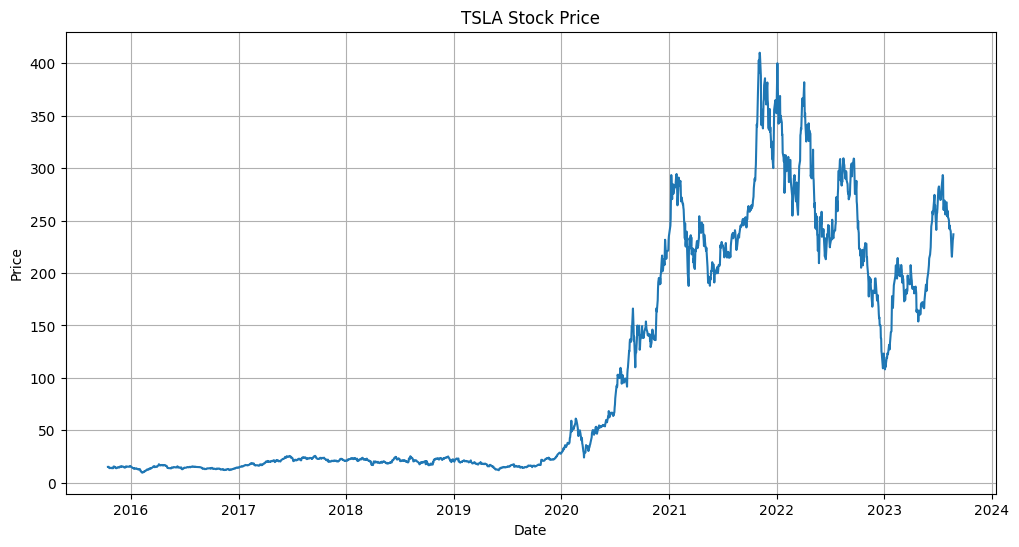

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### TSLA Stock with 20 / 100 / 150 days index of EMA

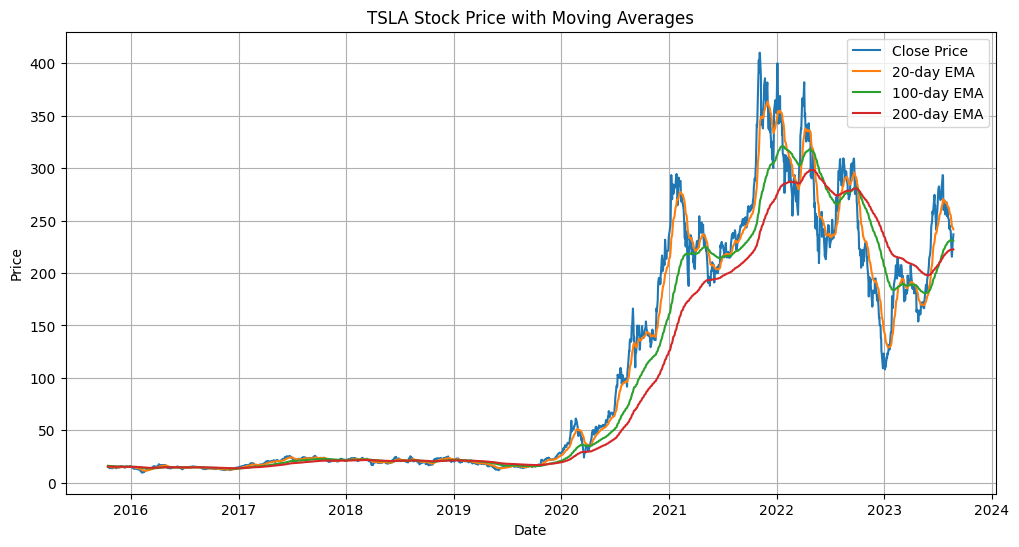

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['EMA20'], label='20-day EMA')
plt.plot(df.index, df['EMA100'], label='100-day EMA')
plt.plot(df.index, df['EMA200'], label='200-day EMA')
plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### RSI Index of the TSLA

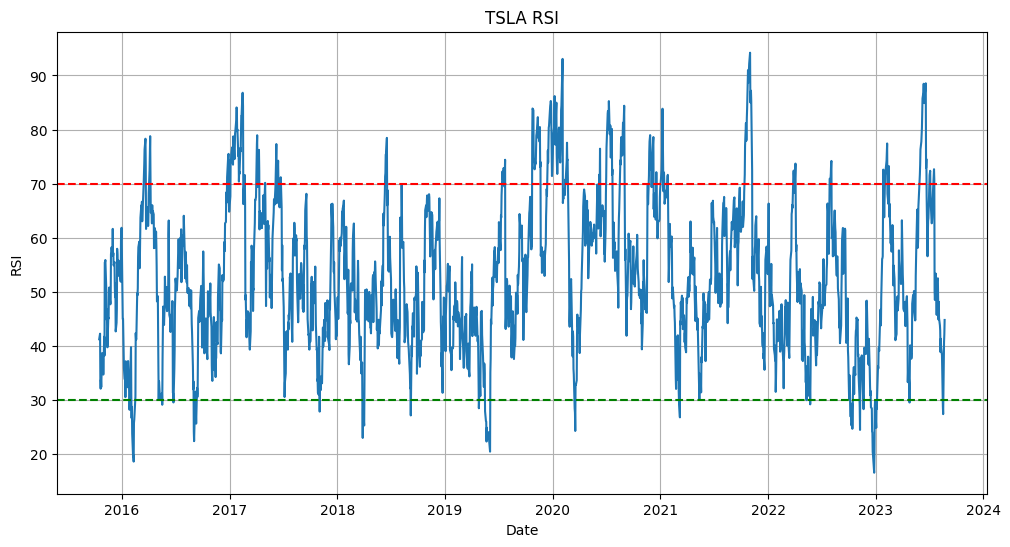

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['RSI'])
plt.title(f'{ticker} RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.grid(True)
plt.show()